# Report plots generation

## General settings

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import scipy
import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from joblib import load, dump

from matplotlib.patches import Ellipse

import trial
import analysis.cosmologies as cosmologies
from analysis.emulator import GPREmulator, MLPREmulator, PerFeatureGPREmulator
from analysis.data_compression.index_compressor import IndexCompressor
from analysis.data_compression.full_grid import FullGrid
from analysis.pipeline import Pipeline
from analysis.data_compression.criteria.chi_squared import ChiSquared
from analysis.data_compression.criteria.fisher_information import FisherInformation
from analysis.data_compression.criteria.correlation_determinant import CorrelationDeterminant
from analysis.data_compression.growing_vector_compressor import GrowingVectorCompressor
from analysis.data_compression.batched_growing_vector_per_zbin_compressor import BatchedGrowingVectorPerZbinCompressor
from utils.file_system import check_folder_exists

In [2]:
cosmology_datas_dir = 'cosmology_datas_los'
# save = False for inspections (plots will appear in notebook) (only one where a lot of repetition happens)
# save = True for generation
save = True

# Save location of plots
plots_dir = 'plots_report'

In [3]:
# Load data
dir = cosmology_datas_dir
slics_data = load(os.path.join(dir, 'slics_data.joblib'))
cosmoslics_datas = load(os.path.join(dir, 'cosmoslics_datas.joblib'))
dist_powers = load(os.path.join(dir, 'dist_powers.joblib'))

## PersistenceDiagram plots

In [4]:
# # one time fix for pd.zbin pd.los fields
# for cosmdata in slics_data + cosmoslics_datas:
# 	for zbin in cosmdata.zbins:
# 		for perdi in cosmdata.zbins_pds[zbin]:
# 			perdi.zbin = zbin
# 			perdi.los = perdi.plot_loc.split('LOS')[-1]

# dump(slics_data, os.path.join(dir, 'slics_data.joblib'))
# dump(cosmoslics_datas, os.path.join(dir, 'cosmoslics_datas.joblib'))
# # dist_powers = load(os.path.join(dir, 'dist_powers.joblib'))

In [5]:
try:
	for cosmdata in tqdm(slics_data + cosmoslics_datas):
		if cosmdata.cosmology not in ['SLICS', 'Cosmol17']:
			continue
		for zbin in cosmdata.zbins:
			for perdi in cosmdata.zbins_pds[zbin]:
				if perdi.los == '25' or perdi.los == '111':
					perdi.set_plots_loc(plots_dir)
					perdi.plot(close=save)

					if not save:
						raise StopIteration
			
except StopIteration:
	pass
	
		

  0%|          | 0/27 [00:00<?, ?it/s]

## BettiNumbersGrid plots

In [6]:
try:
	for cosmdata in tqdm(slics_data + cosmoslics_datas):		
		if cosmdata.cosmology not in ['SLICS', 'Cosmol17']:
			continue
		for zbin in cosmdata.zbins:
			for bng in cosmdata.zbins_bngs_avg[zbin]:
				
				if not save:
					bng.plot()
					raise StopIteration
				else:
					bng.save_figure(os.path.join(plots_dir, 'betti_number_grids', cosmdata.cosmology), save_name=zbin)
			
except StopIteration:
	pass

  0%|          | 0/27 [00:00<?, ?it/s]

## PixelDistinguishingPower plots

In [7]:
try:
	for zbin in dist_powers:
		for dim, pdpmap in enumerate(dist_powers[zbin]):

			if save:
				pdpmap.save_figure(os.path.join(plots_dir, 'pixel_distinguishing_power'), save_name=zbin)
			else:
				pdpmap.plot()
				raise StopIteration
except StopIteration:
	pass


## Compression plots

### ChiSquared

In [117]:
chisq_comp = GrowingVectorCompressor(
	cosmoslics_datas=cosmoslics_datas,
	slics_data=slics_data,
	criterium=ChiSquared(slics_data=slics_data, dist_powers=dist_powers, chisq_increase=.2),
	# inf max data vector length to allow all pixels to be tested
	max_data_vector_length=np.inf,
	minimum_feature_count=50,
	correlation_determinant_criterium=CorrelationDeterminant(.5),
	add_feature_count=False
)

indices_save_path = os.path.join('test_n_indices', 'test_n_indices', 'indices_crit0.npy')
# If there are saved indices, use them
if os.path.exists(indices_save_path):
	indices = np.load(indices_save_path)
	# Set map_indices so compress doesn't go through all pixels again
	chisq_comp.map_indices = indices
	chisq_comp.set_indices(indices)
	# Need to recalculate the criterium values during growth of vector
	chisq_comp._regen_crit_values()
	
chisq_comp.plots_dir = os.path.join(plots_dir, 'chisq_comp')
chisq_comp.compress()


First index (15, 0, 83, 32)


In [119]:

chisq_comp.visualize()
chisq_comp.plot_correlation_matrix()
chisq_comp.plot_covariance_matrix()
chisq_comp.plot_data_vectors(include_slics=True)
chisq_comp.plot_fisher_matrix()
chisq_comp.plot_locations_in_one()

### FisherInformation

In [ ]:
fishinfo_comp = GrowingVectorCompressor(
	cosmoslics_datas=cosmoslics_datas,
	slics_data=slics_data,
	criterium=FisherInformation(cosmoslics_datas=cosmoslics_datas, slics_data=slics_data, fisher_info_increase=.05),
	# inf max data vector length to allow all pixels to be tested
	max_data_vector_length=np.inf,
	minimum_feature_count=50,
	correlation_determinant_criterium=CorrelationDeterminant(.5),
	add_feature_count=False
)

indices_save_path = os.path.join('test_n_indices', 'test_n_indices', 'indices_crit1.npy')
# If there are saved indices, use them
if os.path.exists(indices_save_path):
	indices = np.load(indices_save_path)
	# Set map_indices so compress doesn't go through all pixels again
	fishinfo_comp.map_indices = indices
	fishinfo_comp.set_indices(indices)
	fishinfo_comp._regen_crit_values()
	
fishinfo_comp.plots_dir = os.path.join(plots_dir, 'fishinfo_comp')
fishinfo_comp.compress()


First index (0, 1, 50, 56)


/net/vdesk/data2/bach1/abbo/mrp/mrp/analysis/data_compression/criteria/fisher_information.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  if new_fisher_info / self.prev_fisher_info >= 1. + self.fisher_info_increase:


In [120]:

fishinfo_comp.visualize()
fishinfo_comp.plot_correlation_matrix()
fishinfo_comp.plot_covariance_matrix()
fishinfo_comp.plot_data_vectors(include_slics=True)
fishinfo_comp.plot_fisher_matrix()
fishinfo_comp.plot_locations_in_one()

## Emulation plots

### ChiSquared

In [31]:
chisq_emu = GPREmulator(compressor=chisq_comp)
chisq_emu.plots_dir = os.path.join(plots_dir, 'chisq_emu')
check_folder_exists(chisq_emu.plots_dir)

chisq_emu.validate(make_plot=True)
chisq_emu.fit()
chisq_emu.plot_predictions_over_parameters(save=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


### FisherInformation

In [32]:
fishinfo_emu = GPREmulator(compressor=fishinfo_comp)
fishinfo_emu.plots_dir = os.path.join(plots_dir, 'fishinfo_emu')
check_folder_exists(fishinfo_emu.plots_dir)

fishinfo_emu.validate(make_plot=True)
fishinfo_emu.fit()
fishinfo_emu.plot_predictions_over_parameters(save=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## MCMC

In [ ]:
from data_analysis import run_mcmc, create_sampler_plots

slics_truths = [0.2905, 0.826 * np.sqrt(0.2905 / .3), 0.6898, -1.0]

nwalkers = 500
burn_in_steps = 1000
nsteps = 5000

### ChiSquared

In [ ]:
data_vector = chisq_emu.compressor.avg_slics_data_vector

run_sampler_chisq = run_mcmc(
	chisq_emu,
	data_vector,
	nwalkers=nwalkers,
	burn_in_steps=burn_in_steps,
	nsteps=nsteps,
	llhood='sellentin-heavens',
	progress='notebook',
)


Instantiating MCMC
Covariance matrix inversion
Creating EnsembleSampler
Running burn in


  0%|          | 0/1000 [00:00<?, ?it/s]

Running MCMC


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:

create_sampler_plots(run_sampler_chisq, burn_in_steps, truths=slics_truths, plots_dir=os.path.join(plots_dir, 'chisq_mcmc'))

Generating corner plot


In [ ]:
chains = run_sampler_chisq.get_chain()

print('modes')
modes = []
for i in range(4):
	hist, bin_edges = np.histogram(chains[:, :, i])

	amax = np.argmax(hist)

	modes.append(np.mean(bin_edges[amax:amax+2]))
print(modes)

qs = np.quantile(chains[:, :, :], q=[.16, .5, .84], axis=(0, 1)).T

one_sigmas = [np.mean([q[1] - q[0], q[2] - q[1]]) for q in qs]

mean_dist = []
mode_dist = []

for true, q, one_sig, mode in zip(slics_truths, qs, one_sigmas, modes):
	mean = q[1]

	mean_dist.append(np.abs(mean - true) / one_sig)
	mode_dist.append(np.abs(mode - true) / one_sig)

print(f'{mean_dist=}')
print(f'{mode_dist=}')


modes
[0.32307010382469925, 0.7392070893477547, 0.6988048414179899, -1.060124074391135]
mean_dist=[0.9335774365135588, 1.7575812866052256, 0.6894772805903623, 0.7983782711596489]
mode_dist=[0.525840903352481, 2.167941303690845, 0.2335148423613596, 0.311586276544934]


### FisherInformation

In [ ]:
data_vector = fishinfo_emu.compressor.avg_slics_data_vector

run_sampler_fishinfo = run_mcmc(
	fishinfo_emu,
	data_vector,
	nwalkers=nwalkers,
	burn_in_steps=burn_in_steps,
	nsteps=nsteps,
	llhood='sellentin-heavens',
	progress='notebook',
)


Instantiating MCMC
Covariance matrix inversion
Creating EnsembleSampler
Running burn in


  0%|          | 0/1000 [00:00<?, ?it/s]

Running MCMC


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:

create_sampler_plots(run_sampler_fishinfo, burn_in_steps, truths=slics_truths, plots_dir=os.path.join(plots_dir, 'fishinfo_mcmc'))

Generating corner plot


In [ ]:
chains = run_sampler_fishinfo.get_chain()

print('modes')
modes = []
for i in range(4):
	hist, bin_edges = np.histogram(chains[:, :, i])

	amax = np.argmax(hist)

	modes.append(np.mean(bin_edges[amax:amax+2]))
print(modes)

qs = np.quantile(chains[:, :, :], q=[.16, .5, .84], axis=(0, 1)).T

one_sigmas = [np.mean([q[1] - q[0], q[2] - q[1]]) for q in qs]

mean_dist = []
mode_dist = []

for true, q, one_sig, mode in zip(slics_truths, qs, one_sigmas, modes):
	mean = q[1]

	mean_dist.append(np.abs(mean - true) / one_sig)
	mode_dist.append(np.abs(mode - true) / one_sig)

print(f'{mean_dist=}')
print(f'{mode_dist=}')

modes
[0.2872607880060167, 0.7664112034411247, 0.7145689781235733, -0.9123353211104552]
mean_dist=[0.4998076997265171, 1.0373929319962993, 0.601510729150237, 0.06554187977201162]
mode_dist=[0.05993725896304441, 0.871074504203541, 0.7980189640952888, 0.2950383320471497]


## Test n indices plot

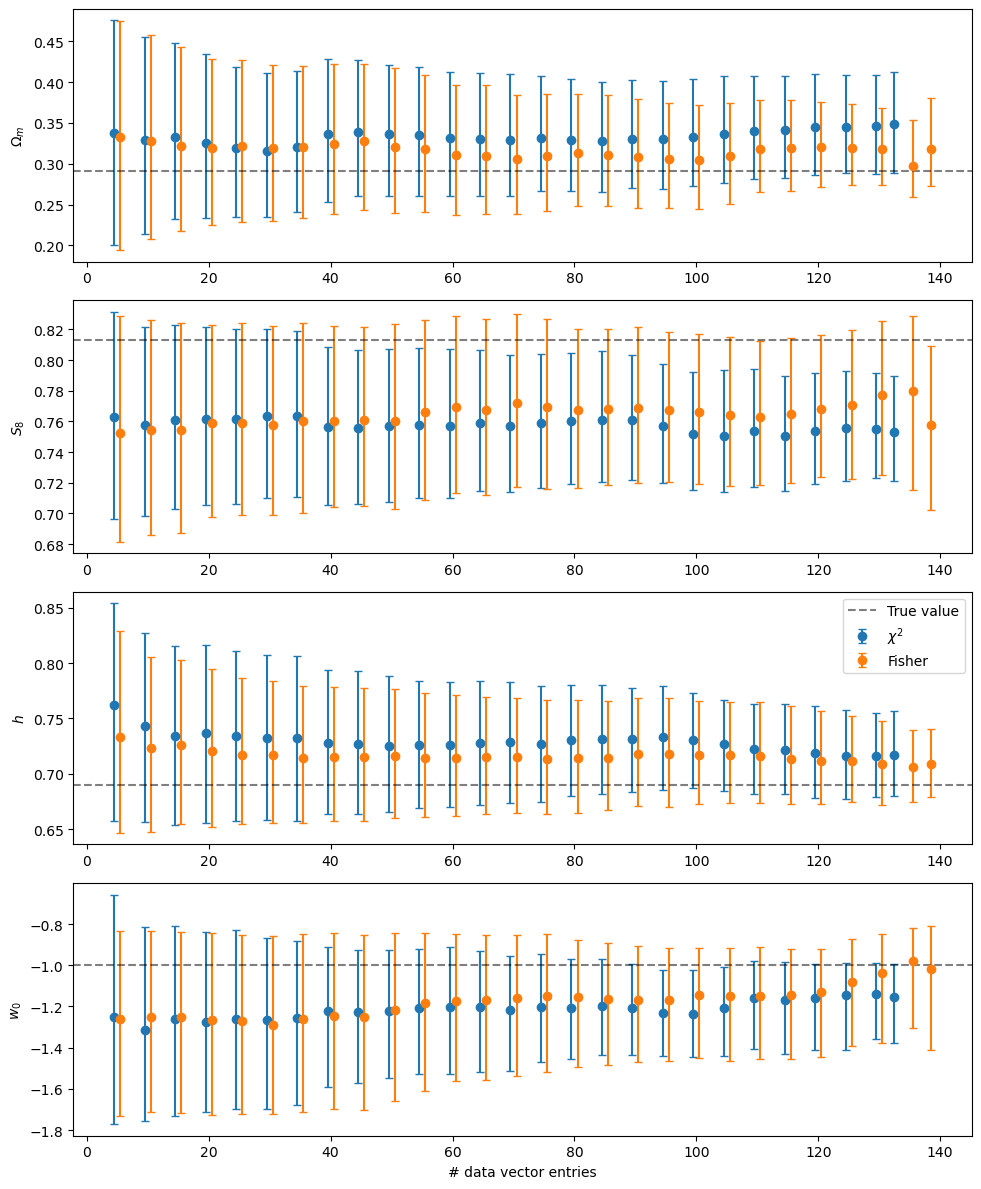

In [5]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 12))

test_res = pd.read_csv(os.path.join('test_n_indices', 'test_n_indices', 'results.csv'))

slics_truths = [0.2905, 0.826 * np.sqrt(0.2905 / .3), 0.6898, -1.0]

params = ['Omega_m', 'S_8', 'h', 'w_0']
labels = ['$\Omega_m$', '$S_8$', '$h$', '$w_0$']
quantiles = [.16, .5, .84]
qs_cols = [
	[f'{p}_q{q}' for q in quantiles] for p in params
]

for i, param in enumerate(params):
	cols = qs_cols[i]

	for j, (crit, lbl) in enumerate(zip(['chisq', 'fishinfo'], ['$\chi^2$', 'Fisher'])):
		n = test_res[test_res['crit'] == crit]['n_ind']
		l = test_res[test_res['crit'] == crit][cols[0]]
		c = test_res[test_res['crit'] == crit][cols[1]]
		h = test_res[test_res['crit'] == crit][cols[2]]

		# Offset x to separate data
		offset = 1
		axs[i].errorbar(x=n - offset / 2. + offset * j, y=c, yerr=[c - l, h - c], fmt='o', label=lbl, capthick=1, capsize=3)
	
	axs[i].set_ylabel(labels[i])
	axs[i].axhline(y=slics_truths[i], color='black', linestyle='--', alpha=.5, label='True value')

axs[2].legend()
axs[-1].set_xlabel('# data vector entries')

fig.tight_layout()
fig.savefig(os.path.join(plots_dir, 'test_n_indices.pdf'))

## Map filtering

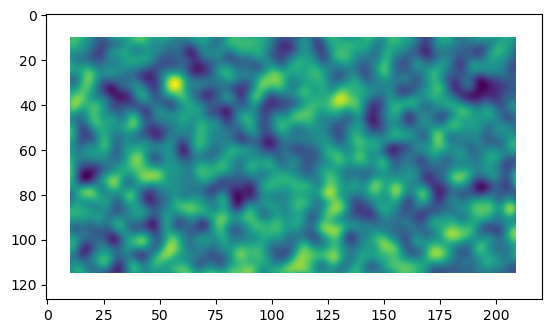

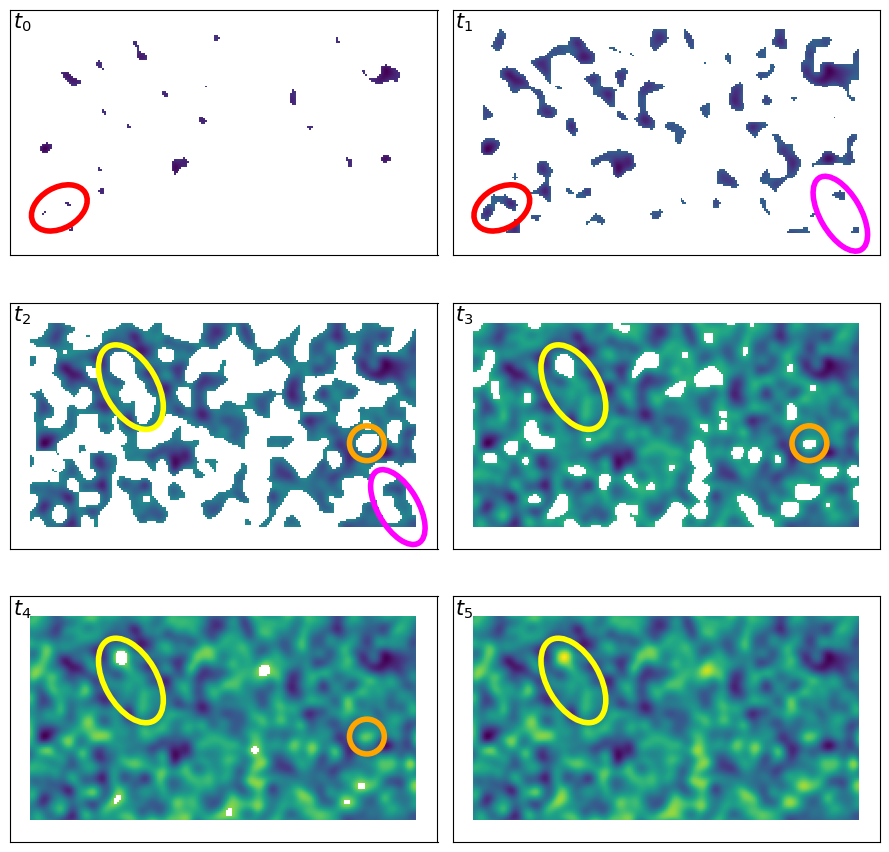

In [3]:
testmap = np.load('maps/MRres140.64arcs_100Sqdeg_SN0.27_Mosaic_KiDS1000GpAM_zKiDS1000_ZBcut0.9-1.2_Cosmol7/SN0.27_Mosaic.KiDS1000GpAM.LOS1R2.SS2.816.Ekappa.npy')
vmin, vmax = np.min(testmap), np.max(testmap)
testmap[testmap == 0.] = np.inf
fig, ax = plt.subplots()
ax.imshow(testmap, vmin=vmin, vmax=vmax)

# Ellipses linewidth
lw = 4

# Setup filters, skip the minimum value as the map will be basically empty

filters = np.linspace(vmin, vmax, 7)[1:]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13.5))



for i, threshold in enumerate(filters):
	ax_index = np.unravel_index(i, (3, 2))
	cax = axs[*ax_index]

	temp = np.copy(testmap)
	temp[temp > threshold] = np.inf

	cax.imshow(temp, vmin=vmin, vmax=vmax)

	# Layout, remove ticks/labels
	cax.set_xticks([])
	cax.set_yticks([])

	# Set threshold text
	cax.text(1, 9, f'$t_{i}$', fontsize=15)

	# Ellipse highlights
	if i == 0 or i == 1:
		e = Ellipse(xy=(25, 102), width=31, height=21, angle=-30, fill=False, edgecolor='red', linewidth=lw)
		cax.add_artist(e)
	
	if i == 1 or i == 2:
		e = Ellipse(xy=(200, 105), width=43, height=21, angle=60, fill=False, edgecolor='magenta', linewidth=lw)
		cax.add_artist(e)
		
	if i in [2, 3, 4]:
		e = Ellipse(xy=(184, 72), width=18, height=18, fill=False, edgecolor='orange', linewidth=lw)
		cax.add_artist(e)
		
	if i in [2, 3, 4, 5]:
		e = Ellipse(xy=(62, 43), width=48, height=27, angle=60, fill=False, edgecolor='yellow', linewidth=lw)
		cax.add_artist(e)

	ax_height = cax.get_window_extent().height

fig.set_figheight(3*ax_height / fig.dpi)
fig.tight_layout()

plt.savefig('plots_report/map_filtering.pdf')

## Single map

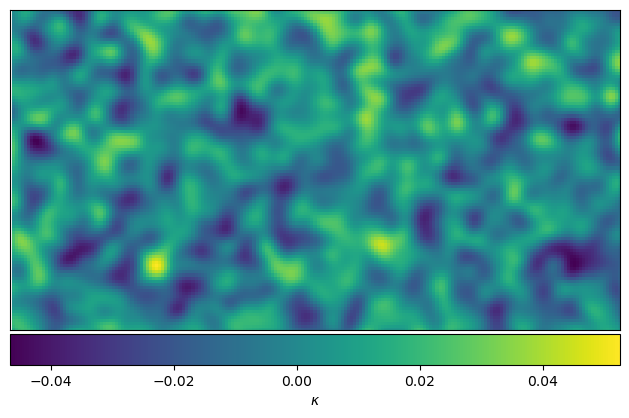

In [24]:
testmap = np.load('maps/MRres140.64arcs_100Sqdeg_SN0.27_Mosaic_KiDS1000GpAM_zKiDS1000_ZBcut0.9-1.2_Cosmol7/SN0.27_Mosaic.KiDS1000GpAM.LOS1R2.SS2.816.Ekappa.npy')
vmin, vmax = np.min(testmap), np.max(testmap)
testmap[testmap == 0.] = np.inf
fig, ax = plt.subplots()
imax = ax.imshow(testmap, vmin=vmin, vmax=vmax)

ax.set_xlim(9, 209)
ax.set_ylim(10, 115)
ax.set_yticks([])
ax.set_xticks([])


cbar = fig.colorbar(imax, orientation='horizontal', location='bottom', fraction=0.1, pad=0.01)
cbar.set_label('$\kappa$')

fig.tight_layout()

fig.savefig('plots_report/single_map.png', dpi=450)
fig.savefig('plots_report/single_map_trans.png', dpi=450, transparent=True)

## Comparing $\chi^2$ and Fisher Information indices

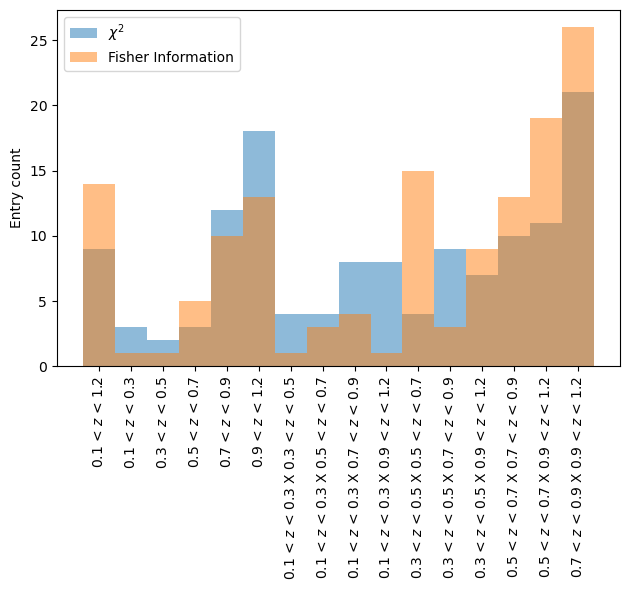

In [ ]:
fig, ax = chisq_comp.plot_entries_per_zbin(save=False, alpha=.5, label='$\chi^2$')

fishinfo_comp.plot_entries_per_zbin(save=False, ax=ax, alpha=.5, label='Fisher Information')

ax.legend()

fig.tight_layout()
fig.savefig('plots_report/comparing_indices.pdf')

## List of indices as Betti functions

In [68]:
def produce_zbin_kappa_table(comp: GrowingVectorCompressor):
	zbins, dims, y_inds, x_inds = comp.indices_t

	# asort = np.argsort(zbins)

	kappa_range = np.linspace(-0.05, 0.05, 101)[1:]
	

	table_content = {
		'zbin': [],
		'dim': [],
		'x': [],
		'y': [],
		'max_betti': []
	}
	# for z, d, x, y in zip(zbins[asort], dims[asort], x_inds[asort], y_inds[asort]):
	for i, z, d, x, y in zip(range(comp.data_vector_length), zbins, dims, x_inds, y_inds):
		table_content['zbin'].append(comp.zbins_labels[z])
		table_content['dim'].append(d)
		table_content['x'].append(kappa_range[x])
		table_content['y'].append(kappa_range[::-1][y])
		table_content['max_betti'].append(comp.max_feature_count[*comp.indices[i]])

	df = pd.DataFrame(table_content)
	to_latex = df.to_latex(
		header=('$z$', 'Dimension', '$t_b$', '$t_d$', '$\max\\beta_n(t_b,t_d)$'), 
		longtable=True,
		formatters=[
			lambda s: s,
			lambda s: s,
			lambda t_b: f'{t_b:.3f}',
			lambda t_d: f'{t_d:.3f}',
			lambda b: f'{b:.0f}'
		]
	)
	print(to_latex)

In [69]:
produce_zbin_kappa_table(chisq_comp)

\begin{longtable}{llrrrr}
\toprule
 & $z$ & Dimension & $t_b$ & $t_d$ & $\max\beta(t_b,t_d)$ \\
\midrule
\endfirsthead
\toprule
 & $z$ & Dimension & $t_b$ & $t_d$ & $\max\beta(t_b,t_d)$ \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.017 & -0.033 & 745 \\
1 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.048 & 0.022 & 465 \\
2 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.022 & -0.021 & 277 \\
3 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.021 & 0.027 & 148 \\
4 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.025 & -0.033 & 150 \\
5 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.042 & 0.030 & 127 \\
6 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.016 & -0.015 & 720 \\
7 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.027 & -0.031 & 85 \\
8 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.022 & -0.012 & 3624 \\
9 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.015 & 0.003 & 2816 \\
10 & 0.7 < $z

In [71]:
produce_zbin_kappa_table(fishinfo_comp)

\begin{longtable}{llrrrr}
\toprule
 & $z$ & Dimension & $t_b$ & $t_d$ & $\max\beta(t_b,t_d)$ \\
\midrule
\endfirsthead
\toprule
 & $z$ & Dimension & $t_b$ & $t_d$ & $\max\beta(t_b,t_d)$ \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.011 & -0.003 & 2770 \\
1 & 0.1 < $z$ < 1.2 & 0 & 0.001 & -0.006 & 2611 \\
2 & 0.1 < $z$ < 1.2 & 1 & 0.007 & -0.002 & 2551 \\
3 & 0.1 < $z$ < 1.2 & 0 & -0.009 & -0.022 & 1315 \\
4 & 0.5 < $z$ < 0.7 X 0.7 < $z$ < 0.9 & 1 & 0.010 & 0.001 & 2499 \\
5 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 1 & 0.018 & 0.005 & 2728 \\
6 & 0.5 < $z$ < 0.7 X 0.7 < $z$ < 0.9 & 0 & -0.003 & -0.007 & 2023 \\
7 & 0.7 < $z$ < 0.9 & 1 & 0.013 & 0.001 & 2444 \\
8 & 0.7 < $z$ < 0.9 X 0.9 < $z$ < 1.2 & 0 & -0.002 & -0.008 & 2218 \\
9 & 0.5 < $z$ < 0.7 X 0.9 < $z$ < 1.2 & 1 & 0.010 & -0.001 & 2605 \\
10 & 0.5 < $z$ < 0.7 X 0.9 < $z$ < 1.2 & 0 & -0.013 & -0.028 & 1203 \\
11 & 0